<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/NorthwesternHeader.png?raw=1">

## MSDS458 Research Assignment 2
<div class="alert alert-block alert-success">
    <b>More Technical</b>: Throughout the notebook. This types of boxes provide more technical details and extra references about what you are seeing. They contain helpful tips, but you can safely skip them the first time you run through the code.
</div><br>

The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.

## Import packages needed 

In [3]:
# Helper libraries
import datetime
from packaging import version
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from collections import Counter
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

In [4]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

### Verify TensorFlow Version and Keras Version

In [5]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.4.1


In [6]:
print("Keras version: ", keras.__version__)

Keras version:  2.4.0


<div class="alert alert-block alert-info">
    <b>Suppress warning messages</b></div>

In [7]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

### Mount Google Drive to Colab Enviorment

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Loading cifar10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.<br>

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.


In [9]:
(train_images, train_labels),(test_images, test_labels)= tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 2s 0us/step


* Tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
* x_train, x_test: uint8 arrays of color image data with shapes (num_samples, 32, 32).
* y_train, y_test: uint8 arrays of digit labels (integers in range 0-9)

## EDA Training and Test Datasets

* Imported 50000 examples for training and 10000 examples for test 
* Imported 50000 labels for training and 10000 labels for test 

In [10]:
print('train_images:\t{}'.format(train_images.shape))
print('train_labels:\t{}'.format(train_labels.shape))
print('test_images:\t\t{}'.format(test_images.shape))
print('test_labels:\t\t{}'.format(test_labels.shape))

train_images:	(50000, 32, 32, 3)
train_labels:	(50000, 1)
test_images:		(10000, 32, 32, 3)
test_labels:		(10000, 1)


### Review labels for training dataset

In [11]:
print("First ten labels training dataset:\n {}\n".format(train_labels[0:10]))
print("This output the numeric label, need to convert to item description")

First ten labels training dataset:
 [[6]
 [9]
 [9]
 [4]
 [1]
 [1]
 [2]
 [7]
 [8]
 [3]]

This output the numeric label, need to convert to item description


### Plot Examples

In [12]:
def get_three_classes(x, y):
    def indices_of(class_id):
        indices, _ = np.where(y == float(class_id))
        return indices

    indices = np.concatenate([indices_of(0), indices_of(1), indices_of(2)], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [13]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [14]:
x_preview, y_preview = get_three_classes(x_train, y_train)
x_preview, y_preview = get_three_classes(x_test, y_test)

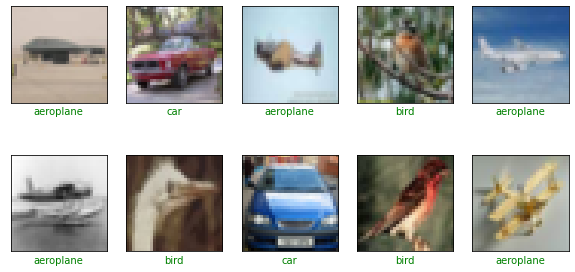

In [15]:
class_names_preview = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, p):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    p = p[indices]
    
    plt.figure(figsize=(10, 5))
    for i in range(10):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(p[i]) else 'red'
        plt.xlabel(class_names_preview[np.argmax(p[i])], color=col)
    plt.show()

show_random_examples(x_preview, y_preview, y_preview)

### Random Review of Examples 

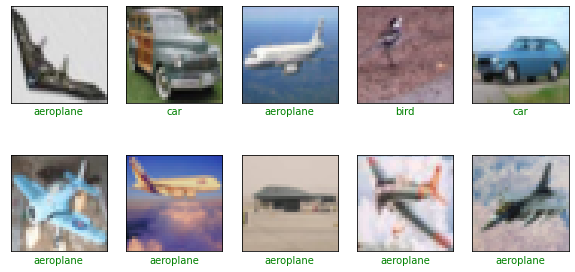

In [16]:
show_random_examples(x_preview, y_preview, y_preview)

## Preprocessing Data for Model Development

The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

|Label  |Class_  |
|-------|--------|
|0|	airplane     |
|1|	automobile   |
|2|	bird         |
|3|	cat          |
|4|	deer         |
|5|	dog          |
|6|	frog         |
|7|	horse        |
|8|	ship         |
|9|	truck        |

In [17]:
class_names = [['airplane'
,'automobile'
,'bird'
,'cat'
,'deer'
,'dog'
,'frog' 
,'horse'
,'ship'
,'truck']]

### Preprocessing the Examples
 The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255.
 

1. Each element in each example is a pixel value
2. Pixel values range from 0 to 255
3. 0 = black
4. 255 = white

In [18]:
train_images_norm = train_images.astype('float32')/255.
test_images_norm = test_images.astype('float32')/255.

In [19]:
train_images_norm.shape, test_images_norm.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

## Validating our approach

10,000 samples of our training data to use as a validation set. 

In [20]:
val_images_norm, train_images_norm = train_images_norm[:10000], train_images_norm[10000:] 
val_labels, train_labels = train_labels[:10000], train_labels[10000:]

In [21]:
val_images_norm.shape, val_labels.shape

((10000, 32, 32, 3), (10000, 1))

In [22]:
train_images_norm.shape, train_labels.shape

((40000, 32, 32, 3), (40000, 1))

## Create the Model

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/CNN_architecture_v4.png?raw=1">


### Build CNN Model

We use a Sequential class defined in Keras to create our model. The first 4 layers Conv2D and MaxPooling handle feature learning.  The last 3 layers, handle classification.  

In [23]:
model = models.Sequential()
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu, input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2),strides=2))
model.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation=tf.nn.relu))
model.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 512)       1180160   
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 512)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 1024)        4719616   
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

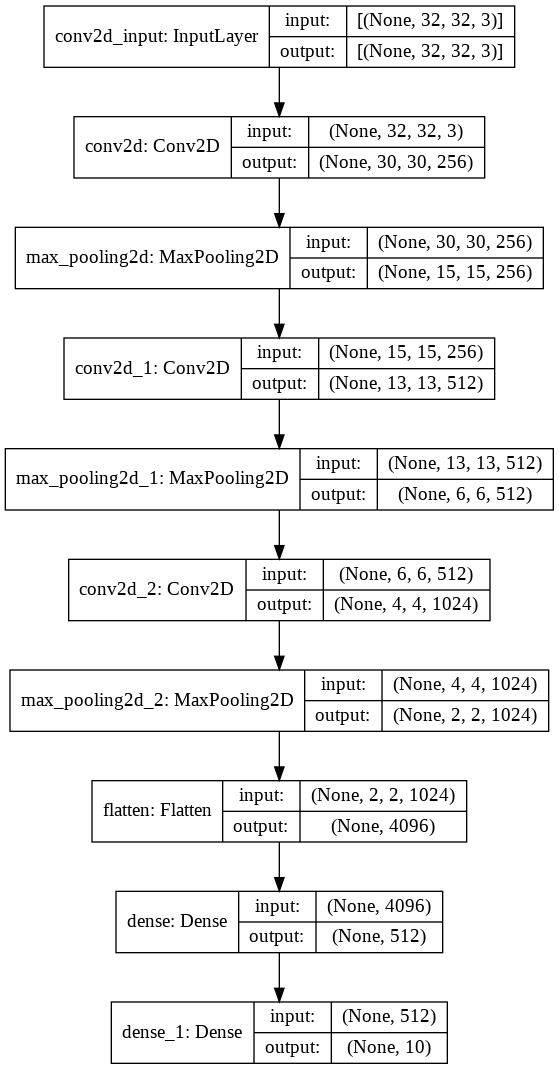

In [25]:
keras.utils.plot_model(model, "CIFAR10.png", show_shapes=True) 

### Compiling the model

In addition to setting up our model architecture, we also need to define which algorithm should the model use in order to optimize the weights and biases as per the given data. We will use stochastic gradient descent.

We also need to define a loss function. Think of this function as the difference between the predicted outputs and the actual outputs given in the dataset. This loss needs to be minimised in order to have a higher model accuracy. That's what the optimization algorithm essentially does - it minimises the loss during model training. For our multi-class classification problem, categorical cross entropy is commonly used.

Finally, we will use the accuracy during training as a metric to keep track of as the model trains.

<div class="alert alert-block alert-info">
<b>tf.keras.losses.SparseCategoricalCrossentropy</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy</div>

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

## Training the model

<div class="alert alert-block alert-success">
    <b>Module: tf.keras.callbacks</b></div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.EarlyStopping</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping</div>

<div class="alert alert-block alert-info">
<b>tf.keras.callbacks.ModelCheckpoint</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint</div>

In [27]:
history = model.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                           
                   )

Epoch 1/20
48/79 [=================>............] - ETA: 2s - loss: 2.1804 - accuracy: 0.1916

KeyboardInterrupt: ignored

### Validation Data
Data on which to evaluate the loss and any model metrics at the end of each epoch<br>
The model will not be trained on this data

## Evaluate the model

In order to ensure that this is not a simple "memorization" by the machine, we should evaluate the performance on the test set. This is easy to do, we simply use the `evaluate` method on our model.

In [ ]:
loss, accuracy = model.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

## Predictions

In [ ]:
preds = model.predict(test_images_norm)
print('shape of preds: ', preds.shape)

## Plotting Performance Metrics 

We use Matplotlib to create 2 plots--displaying the training and validation loss (resp. accuracy) for each (training) epoch side by side.

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

## Creating confusion matrices

Let us see what the confusion matrix looks like. Using both `sklearn.metrics`. Then we visualize the confusion matrix and see what that tells us.

Get the predicted classes

In [ ]:
pred_classes = np.argmax(model.predict(train_images_norm), axis=-1)
pred_classes

### Visualizing the confusion matrix

In [ ]:
conf_mx = tf.math.confusion_matrix(train_labels, pred_classes)
conf_mx

In [ ]:
plt.figure(figsize=(16,8))
plt.matshow(conf_mx, cmap=plt.cm.Blues,fignum=1)
plt.xlabel("Predicted Classes")
plt.ylabel("Actual Classes")
plt.show()

### Load HDF5 Model Format 

<div class="alert alert-block alert-info">
<b>tf.keras.models.load_model</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/models/load_model</div>

In [ ]:
model = tf.keras.models.load_model('/content/gdrive/My Drive/Colab Notebooks/model_0.6925.h5')

In [ ]:
preds = model.predict(test_images_norm)

In [ ]:
preds.shape

In [ ]:
print("The first predictions\n {}\n".format(preds[0]))

In [ ]:
print(class_names)

In [ ]:
print("First ten entries of the predictions:\n {}\n".format(preds[0:20]))

### Predictions

In [ ]:
cm = sns.light_palette((260, 75, 60), input="husl", as_cmap=True)

In [ ]:
df = pd.DataFrame(preds[0:20], columns = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])
df.style.format("{:.2%}").background_gradient(cmap=cm)

# EXPERIMENT 1

In [ ]:
model1 = models.Sequential()
model1.add(layers.Dense(units=64, activation=tf.nn.relu))
model1.add(layers.Dense(units=64, activation=tf.nn.relu))
model1.add(layers.Flatten())
model1.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
from time import perf_counter 
time = perf_counter()
history1 = model1.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                         
                   )

In [ ]:
time2 = perf_counter() - time
print(time2)

In [ ]:
loss, accuracy = model1.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

In [ ]:
history_dict = history1.history
history_dict.keys()
history_df=pd.DataFrame(history_dict)
history_df.tail()

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred_classes = np.argmax(model1.predict(train_images_norm), axis=-1)

In [ ]:
conf_mx = tf.math.confusion_matrix(train_labels, pred_classes)
conf_mx

# Experiment 2

In [ ]:
model2 = models.Sequential()
model2.add(layers.Dense(units=64, activation=tf.nn.relu))
model2.add(layers.Dense(units=64, activation=tf.nn.relu))
model2.add(layers.Dense(units=64, activation=tf.nn.relu))
model2.add(layers.Flatten())
model2.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
time = perf_counter()
history2 = model2.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                         
                   )

In [ ]:
time2 = perf_counter() - time
print(time2)

In [ ]:
loss, accuracy = model2.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

In [ ]:
history_dict = history2.history
history_dict.keys()
history_df=pd.DataFrame(history_dict)
history_df.tail()

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred_classes = np.argmax(model2.predict(train_images_norm), axis=-1)

In [ ]:
conf_mx = tf.math.confusion_matrix(train_labels, pred_classes)
conf_mx

# Experiment 3

In [ ]:
model3 = models.Sequential()
model3.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model3.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model3.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model3.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model3.add(layers.Flatten())
model3.add(layers.Dense(units=512, activation=tf.nn.relu))
model3.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
from time import perf_counter 
time = perf_counter()
history3 = model3.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                           
                   )

In [ ]:
time2 = perf_counter() - time
print(time2)

In [ ]:
loss, accuracy = model3.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

In [ ]:
history_dict = history3.history
history_dict.keys()
history_df=pd.DataFrame(history_dict)
history_df.tail()

In [ ]:
losses = history3.history['loss']
accs = history3.history['accuracy']
val_losses = history3.history['val_loss']
val_accs = history3.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred_classes = np.argmax(model3.predict(train_images_norm), axis=-1)

In [ ]:
conf_mx = tf.math.confusion_matrix(train_labels, pred_classes)
conf_mx

In [ ]:
from keras.preprocessing import image
import numpy as np



img_tensor = image.img_to_array(test_images[2004])
img_tensor = np.expand_dims(img_tensor, axis=0)
# Remember that the model was trained on inputs
# that were preprocessed in the following way:
img_tensor /= 255.


from keras import models

# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in model3.layers[:2]]
# Creates a model that will return these outputs, given the model input:
activation_model = models.Model(inputs=model3.input, outputs=layer_outputs)

# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model.predict(img_tensor)

first_layer_activation = activations[0]
print(first_layer_activation.shape)


import keras

# These are the names of the layers, so can have them as part of our plot
layer_names = []
for layer in model3.layers[:2]:
    layer_names.append(layer.name)

images_per_row = 8

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()




        

# Experiment 4

In [ ]:
model4 = models.Sequential()
model4.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model4.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model4.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model4.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model4.add(layers.Flatten())
model4.add(layers.Dense(units=512, activation=tf.nn.relu))
model4.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
time = perf_counter()
history4 = model4.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                         
                   )

In [ ]:
time2 = perf_counter() - time
print(time2)

In [ ]:
loss, accuracy = model4.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

In [ ]:
history_dict = history4.history
history_dict.keys()
history_df=pd.DataFrame(history_dict)
history_df.tail()

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred_classes = np.argmax(model4.predict(train_images_norm), axis=-1)

In [ ]:
conf_mx = tf.math.confusion_matrix(train_labels, pred_classes)
conf_mx

# Experiment 5

In [ ]:
model5 = models.Sequential()
model5.add(layers.Dense(units=64, activation=tf.nn.relu))
model5.add(layers.Dense(units=64, activation=tf.nn.relu))
model5.add(layers.Flatten())
model5.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
time = perf_counter()
history5 = model5.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)  
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                      
                   )

In [ ]:
time2 = perf_counter() - time
print(time2)

In [ ]:
loss, accuracy = model5.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

In [ ]:
history_dict = history5.history
history_dict.keys()
history_df=pd.DataFrame(history_dict)
history_df.tail()

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred_classes = np.argmax(model5.predict(train_images_norm), axis=-1)

In [ ]:
conf_mx = tf.math.confusion_matrix(train_labels, pred_classes)
conf_mx

# Experiment 6

In [ ]:
model6 = models.Sequential()
model6.add(layers.Dense(units=64, activation=tf.nn.relu))
model6.add(layers.Dense(units=64, activation=tf.nn.relu))
model6.add(layers.Dense(units=64, activation=tf.nn.relu))
model6.add(layers.Flatten())
model6.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
time = perf_counter()
history6 = model6.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)   
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                       
)

In [ ]:
time2 = perf_counter() - time
print(time2)

In [ ]:
loss, accuracy = model6.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

In [ ]:
history_dict = history6.history
history_dict.keys()
history_df=pd.DataFrame(history_dict)
history_df.tail()

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred_classes = np.argmax(model6.predict(train_images_norm), axis=-1)

In [ ]:
conf_mx = tf.math.confusion_matrix(train_labels, pred_classes)
conf_mx

# Experiment 7

In [ ]:

model7 = models.Sequential()
model7.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model7.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model7.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model7.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model7.add(layers.Flatten())
model7.add(layers.Dense(units=512, activation=tf.nn.relu))
model7.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model7.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
time = perf_counter()
history7 = model7.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                          
                   )

In [ ]:
time2 = perf_counter() - time
print(time2)

In [ ]:
loss, accuracy = model7.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

In [ ]:
history_dict = history7.history
history_dict.keys()
history_df=pd.DataFrame(history_dict)
history_df.tail()

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred_classes = np.argmax(model7.predict(train_images_norm), axis=-1)

In [ ]:
conf_mx = tf.math.confusion_matrix(train_labels, pred_classes)
conf_mx

In [ ]:
pred_classestest = np.argmax(model7.predict(test_images_norm), axis=-1)
conf_mx = tf.math.confusion_matrix(test_labels, pred_classestest)
conf_mx

In [ ]:
from sklearn.metrics import precision_score
precision_score(test_labels, pred_classestest, average='micro')

In [ ]:
precision_score(train_labels, pred_classes,  average='micro')

# Experiment8

In [ ]:
model8 = models.Sequential()
model8.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model8.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model8.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model8.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model8.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model8.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model8.add(layers.Flatten())
model8.add(layers.Dense(units=512, activation=tf.nn.relu))
model8.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model8.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
time = perf_counter()
history8 = model8.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2),
                    tf.keras.callbacks.ModelCheckpoint('/content/gdrive/My Drive/Colab Notebooks/model_{val_accuracy:.4f}.h5', save_best_only=True,
                                        save_weights_only=False, monitor='val_accuracy')]                                                                                                          
                   )

In [ ]:
time2 = perf_counter() - time
print(time2)

In [ ]:
loss, accuracy = model8.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

In [ ]:
history_dict = history8.history
history_dict.keys()
history_df=pd.DataFrame(history_dict)
history_df.tail()

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred_classes = np.argmax(model8.predict(train_images_norm), axis=-1)

In [ ]:
conf_mx = tf.math.confusion_matrix(train_labels, pred_classes)
conf_mx

In [ ]:
pred_classestest = np.argmax(model8.predict(test_images_norm), axis=-1)

In [ ]:
conf_mx = tf.math.confusion_matrix(test_labels, pred_classestest)
conf_mx

In [ ]:
precision_score(test_labels, pred_classestest, average='micro')

In [ ]:
precision_score(train_labels, pred_classes,  average='micro')

# Experiment 9

In [ ]:
model9 = models.Sequential()
model9.add(layers.Dense(units=128, kernel_regularizer='l1_l2', activation=tf.nn.relu))
model9.add(layers.Dense(units=128, kernel_regularizer='l1_l2', activation=tf.nn.relu))
model9.add(layers.Flatten())
model9.add(layers.Dense(units=10, kernel_regularizer='l1_l2', activation=tf.nn.softmax))

In [ ]:
model9.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
time = perf_counter()
history9 = model9.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                       
                   )

In [ ]:
time2 = perf_counter() - time
print(time2)

In [ ]:
loss, accuracy = model9.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

In [ ]:
history_dict = history9.history
history_dict.keys()
history_df=pd.DataFrame(history_dict)
history_df.tail()

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred_classes = np.argmax(model9.predict(train_images_norm), axis=-1)

In [ ]:
conf_mx = tf.math.confusion_matrix(train_labels, pred_classes)
conf_mx

# Experiment 10

In [ ]:
model10 = models.Sequential()
model10.add(layers.Dense(units=128, kernel_regularizer='l1_l2', activation=tf.nn.relu))
model10.add(layers.Dense(units=128, kernel_regularizer='l1_l2', activation=tf.nn.relu))
model10.add(layers.Dense(units=128, kernel_regularizer='l1_l2', activation=tf.nn.relu))
model10.add(layers.Flatten())
model10.add(layers.Dense(units=10, kernel_regularizer='l1_l2', activation=tf.nn.softmax))

In [ ]:
model10.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
time = perf_counter()
history10 = model10.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                       
                   )

In [ ]:
time2 = perf_counter() - time
print(time2)

In [ ]:
loss, accuracy = model10.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

In [ ]:
history_dict = history10.history
history_dict.keys()
history_df=pd.DataFrame(history_dict)
history_df.tail()

# Experiment 11

In [ ]:

model11 = models.Sequential()
model11.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model11.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model11.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model11.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model11.add(layers.Flatten())
model11.add(layers.Dense(units=512, kernel_regularizer='l1_l2', activation=tf.nn.relu))
model11.add(layers.Dense(units=10, kernel_regularizer='l1_l2', activation=tf.nn.softmax))

In [ ]:
model11.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
time = perf_counter()
history11 = model11.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                       
                   )

In [ ]:
time2 = perf_counter() - time
print(time2)

In [ ]:
loss, accuracy = model11.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

In [ ]:
history_dict = history11.history
history_dict.keys()
history_df=pd.DataFrame(history_dict)
history_df.tail()

In [ ]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred_classes = np.argmax(model10.predict(train_images_norm), axis=-1)

In [ ]:
conf_mx = tf.math.confusion_matrix(train_labels, pred_classes)
conf_mx

# EXPERIMENT 12

In [ ]:
model12 = models.Sequential()
model12.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model12.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model12.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model12.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model12.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model12.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model12.add(layers.Flatten())
model12.add(layers.Dense(units=512, kernel_regularizer='l1_l2', activation=tf.nn.relu))
model12.add(layers.Dense(units=10, kernel_regularizer='l1_l2', activation=tf.nn.softmax))

In [ ]:
model12.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
time = perf_counter()
history12 = model12.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                       
                   )

In [ ]:
time2 = perf_counter() - time
print(time2)

In [ ]:
loss, accuracy = model12.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

# Experiment 13

In [ ]:
model13 = models.Sequential()
model13.add(layers.Dense(units=512, activation=tf.nn.relu))
model13.add(layers.Dense(units=512, activation=tf.nn.relu))
model13.add(Dropout(0.2))
model13.add(layers.Flatten())
model13.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model13.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
time = perf_counter()
history13 = model13.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                       
                   )

In [ ]:
time2 = perf_counter() - time
print(time2)

In [ ]:
loss, accuracy = model13.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

# Experiment 14

In [ ]:
model14 = models.Sequential()
model14.add(layers.Dense(units=512, activation=tf.nn.relu))
model14.add(layers.Dense(units=512, activation=tf.nn.relu))
model14.add(Dropout(0.2))
model14.add(layers.Dense(units=512, activation=tf.nn.relu))
model14.add(layers.Flatten())
model14.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model14.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
time = perf_counter()
history14 = model14.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                       
                   )

In [ ]:
time2 = perf_counter() - time
print(time2)

In [ ]:
loss, accuracy = model14.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

# Experiment 15

In [ ]:
model15 = models.Sequential()
model15.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model15.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model15.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model15.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model15.add(Dropout(0.2))
model15.add(layers.Flatten())
model15.add(layers.Dense(units=512,activation=tf.nn.relu))
model15.add(layers.Dense(units=10, activation=tf.nn.softmax))

In [ ]:
model15.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
time = perf_counter()
history15 = model15.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                       
                   )

In [ ]:
time2 = perf_counter() - time
print(time2)

In [ ]:
loss, accuracy = model15.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

# Experiment 16

In [28]:
model16 = models.Sequential()
model16.add(layers.Conv2D(filters=512, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model16.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model16.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model16.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model16.add(Dropout(0.2))
model16.add(layers.Conv2D(filters=1024, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model16.add(layers.MaxPooling2D(pool_size=(2, 2),strides=2))
model16.add(layers.Flatten())
model16.add(layers.Dense(units=512,activation=tf.nn.relu))
model16.add(layers.Dense(units=10,activation=tf.nn.softmax))

In [29]:
model16.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [30]:
#time = perf_counter()
history16 = model16.fit(train_images_norm
                    ,train_labels
                    ,epochs=20
                    ,batch_size=512
                    ,validation_data=(val_images_norm,val_labels)                                                                                                       
                   )

Epoch 1/20
79/79 [==============================] - 20s 223ms/step - loss: 2.1114 - accuracy: 0.2166 - val_loss: 1.6460 - val_accuracy: 0.3969
Epoch 2/20
79/79 [==============================] - 16s 208ms/step - loss: 1.4808 - accuracy: 0.4637 - val_loss: 1.2482 - val_accuracy: 0.5539
Epoch 3/20
79/79 [==============================] - 16s 207ms/step - loss: 1.2354 - accuracy: 0.5608 - val_loss: 1.1265 - val_accuracy: 0.6014
Epoch 4/20
79/79 [==============================] - 16s 207ms/step - loss: 1.0325 - accuracy: 0.6409 - val_loss: 0.9720 - val_accuracy: 0.6573
Epoch 5/20
79/79 [==============================] - 16s 207ms/step - loss: 0.9452 - accuracy: 0.6732 - val_loss: 0.9074 - val_accuracy: 0.6877
Epoch 6/20
79/79 [==============================] - 16s 207ms/step - loss: 0.8265 - accuracy: 0.7150 - val_loss: 0.8394 - val_accuracy: 0.7088
Epoch 7/20
79/79 [==============================] - 16s 207ms/step - loss: 0.7142 - accuracy: 0.7540 - val_loss: 0.8342 - val_accuracy: 0.7084

In [ ]:
time2 = perf_counter() - time
print(time2)

In [31]:
loss, accuracy = model16.evaluate(test_images_norm, test_labels)
print('test set accuracy: ', accuracy * 100)

313/313 [==============================] - 3s 8ms/step - loss: 1.1476 - accuracy: 0.7483
test set accuracy:  74.83000159263611


In [32]:
history_dict = history16.history
history_dict.keys()
history_df=pd.DataFrame(history_dict)
history_df.tail()

,loss,accuracy,val_loss,val_accuracy
15,0.157892,0.945200,0.904099,0.7555
16,0.135336,0.954100,1.010051,0.7514
17,0.115368,0.961325,1.085448,0.7435
18,0.122782,0.958125,0.998898,0.7606
19,0.083785,0.972150,1.079883,0.7621


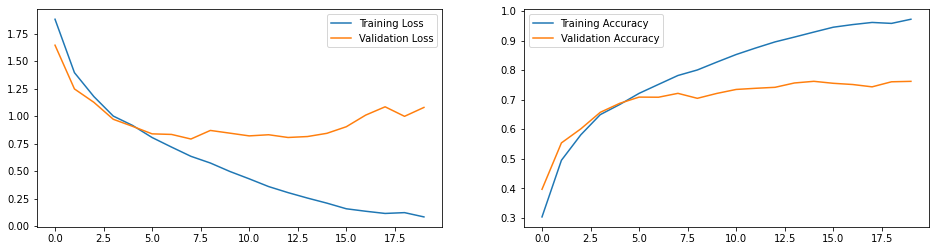

In [33]:
losses = history16.history['loss']
accs = history16.history['accuracy']
val_losses = history16.history['val_loss']
val_accs = history16.history['val_accuracy']
epochs = len(losses)

plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
pred_classes = np.argmax(model16.predict(train_images_norm), axis=-1)

In [ ]:
conf_mx = tf.math.confusion_matrix(train_labels, pred_classes)
conf_mx

In [ ]:
pred_classestest = np.argmax(model16.predict(test_images_norm), axis=-1)

In [ ]:
conf_mx = tf.math.confusion_matrix(test_labels, pred_classestest)
conf_mx

In [ ]:
precision_score(train_labels, pred_classes,  average='micro')

In [ ]:
precision_score(test_labels, pred_classestest,  average='micro')

In [ ]:
layer_outputs = [layer.output for layer in model16.layers]
activation_model = models.Model(inputs=model16.input, outputs=layer_outputs)
layer_outputs

In [ ]:
# Get the outputs of all the hidden nodes for each of the 60000 training images
activations = activation_model.predict(train_images_norm[0:1000])
hidden_layer_activation = activations[8]
output_layer_activations = activations[9]
hidden_layer_activation.shape   #  each of the 128 hidden nodes has one activation value per training image

In [ ]:
#Get the dataframe of all the node values
activation_data = {'pred_class':pred_classes[0:1000]}
for k in range(0,512): 
    activation_data[f"act_val_{k}"] = hidden_layer_activation[:,k]

activation_df = pd.DataFrame(activation_data)
activation_df.head()

In [ ]:
# Separating out the features
features = [*activation_data][1:] # ['act_val_0', 'act_val_1',...]
x = activation_df.loc[:, features].values 

pca = PCA(n_components=3)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pca-one', 'pca-two', 'pca-three'])
principalDf.head()

In [ ]:
pca.explained_variance_ratio_


In [ ]:
activation_pca_df = pd.concat([principalDf, activation_df[['pred_class']]], axis = 1)
activation_pca_df.head()


In [ ]:
N=10000
activation_df_subset = activation_df.iloc[:N].copy()
activation_df_subset.shape

In [ ]:
data_subset = activation_df_subset[features].values
data_subset.shape

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)


In [ ]:
activation_df_subset['tsne-2d-one'] = tsne_results[:,0]
activation_df_subset['tsne-2d-two'] = tsne_results[:,1]

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="pred_class",
    palette=sns.color_palette("hls", 10),
    data=activation_df_subset,
    legend="full",
    alpha=0.3
)